In [2]:
import sys
sys.path.append("../../")
import qsimcirq
import cirq
import numpy as np
import importlib
importlib.reload(qsimcirq)
import matplotlib.pyplot as plt
from typing import List, Union

sys.path.append("../weightedMaxCut")
import grouping_cascades
import gen_weightedMaxCut

import random
import time
import itertools

# Example Circuits for joint cutting with `cirq` interface.

This notebook provides a few examples which show the usage of the `cirq` interface to perform joint cutting. Most importantly, one has to indicate blocks by summarizing them in a `qsimcirq.BlockGate` prior to adding it to the total circuit.

In [3]:
def generate_bitstrings(n):
    return [i for i in range(2**n)]

def bitstring_to_decimal(bitstring: List[int]) -> int:
    return int("".join(map(str, bitstring)), 2)


def generate_lim_bitstrings(n, lim):
    list_bitstrings = []
    for i,v in enumerate(itertools.product([0,1], repeat=n)):
        list_bitstrings.append(bitstring_to_decimal(list(v)))
        if i == lim:
            break
    return list_bitstrings


In [4]:
def run_qsimh(n:int, k:List[int], p:int, r:int, w:int, circuit_block:cirq.circuits.circuit.Circuit, lim:Union[int, None] = None):
    """runs the qsimh simulation of a given cirq circuit 
    Note that joint cutting is only performed if you partition the desired gates as a block via `qsimcirq.BlockGate`.

    Args:
        n (int): number of qubits in the system
        k (List[int]): denotes which qubits are in which partition in the cut, e.g. k=[0,1] means that qubit 0 and 1 are in the first partition and qubit 2... in the other
        p (int): number of prefix gates
        r (int): number of root gates
        w (int): prefix value
        circuit_block (cirq.circuits.circuit.Circuit): circuit to be simulated
        lim: int,None. limits the number of included amplitudes

    Returns:
        resulting statevector as array
    """
    options = {}
    options['k'] = k
    options['p'] = p
    options['r'] = r
    options['w'] = w

    if lim == None:
        bitstrings_list = generate_bitstrings(n)
    else:
        bitstrings_list = generate_lim_bitstrings(n, lim)

    print("bitstrings generated")

    qsimh_simulator = qsimcirq.QSimhSimulator(options)
    results = qsimh_simulator.compute_amplitudes(
        circuit_block, bitstrings=bitstrings_list)

    return results

In [5]:
def run_qsim(n:int, circuit_noblock:cirq.circuits.circuit.Circuit, lim:Union[int,None]=None):
    """runs qsim simulation of a given cirq circuit. 
    Note that this CANNOT handle circuits containing `qsimcirq.BlockGate`. Only qsimh can handle such blocks.

    Args:
        n (int): number of qubits in the system
        circuit_noblock (cirq.circuits.circuit.Circuit): circuit to be simulated
        lim: int,None. limits the number of included amplitudes

    Returns:
        resulting statevector as array
    """
    if lim == None:
        bitstrings_list = generate_bitstrings(n)
    else:
        bitstrings_list = generate_lim_bitstrings(n, lim)

    qsim_simulator = qsimcirq.QSimSimulator()
    results = qsim_simulator.compute_amplitudes(circuit_noblock, bitstrings=bitstrings_list)
    return results

### Bell state preparation

In [5]:
# Define qubits
n=3
q0 = cirq.LineQubit(0)
q1 = cirq.LineQubit(1)
q2 = cirq.LineQubit(2)

block_gate2 = qsimcirq.BlockGate([
    cirq.CNOT(q1, q0),
    cirq.CNOT(q1, q2)
])

# Create a circuit and add the BlockOperation
circuit_block = cirq.Circuit(
    cirq.H(q1),
    block_gate2(q0,q1,q2),  # Add the BlockOperation directly

)
print("Circuit (block):")
print(circuit_block)


Circuit (block):
0: ───────BlockGate(CNOT(q(1), q(0)), CNOT(q(1), q(2)))───
          │
1: ───H───#2──────────────────────────────────────────────
          │
2: ───────#3──────────────────────────────────────────────


In [6]:
circuit_noblock = cirq.Circuit(
    cirq.H(q1),
    cirq.CNOT(q1, q0),
    cirq.CNOT(q1, q2)    
)
print("Circuit (no block):")
print(circuit_noblock)

Circuit (no block):
0: ───────X───────
          │
1: ───H───@───@───
              │
2: ───────────X───


In [23]:
results_0 = run_qsimh(n, [0], 0, 1, 0, circuit_block)
print("qsimh result:")
print(results_0)

bitstrings generated
qsimh result:
[(0.7071067690849304+0j), (8.429368136830817e-08+0j), 0j, 0j, 0j, 0j, (8.429367426288081e-08+0j), (0.7071065902709961+0j)]
rmax: 2
smax: 1
Number of Feynman Paths: 2


In [8]:
results_noblock = run_qsim(n, circuit_noblock)
print("qsim results:")
print(results_noblock)

qsim results:
[(0.7071067690849304+0j), 0j, 0j, 0j, 0j, 0j, 0j, (0.7071067690849304+0j)]


In [9]:
results_0 = np.array(results_0)
results_noblock = np.array(results_noblock)
np.linalg.norm(results_0 - results_noblock)

2.149075879269111e-07

### Small instances of QAOA for Max Cut

#### $q=20$

In [25]:
q = 20
seed = 16
cut_loc = 9
sizes = [10,10]
p_intra = 0.8
p_inter = 0.05
angles = [1.55739, 2.32636]
save_plot = False
verbose = True

Cascades prior to limiting their size
('19', [(1, 19), (3, 19), (7, 19)])
('1', [(1, 17)])
('3', [(3, 14)])
('15', [(5, 15), (6, 15)])
('0', [(0, 13)])
('remainder', [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 9), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (4, 5), (4, 7), (4, 8), (5, 7), (5, 8), (5, 9), (6, 7), (6, 8), (6, 9), (7, 8), (7, 9), (8, 9), (10, 11), (10, 12), (10, 13), (10, 14), (10, 15), (10, 16), (10, 17), (10, 18), (10, 19), (11, 13), (11, 14), (11, 16), (11, 17), (11, 18), (11, 19), (12, 13), (12, 14), (12, 16), (12, 17), (12, 19), (13, 14), (13, 15), (13, 16), (13, 17), (13, 18), (13, 19), (14, 16), (14, 17), (14, 18), (14, 19), (15, 16), (15, 17), (15, 18), (15, 19), (16, 17), (16, 18), (16, 19), (17, 19), (18, 19)])
Cascades after limiting their size
('remainder', [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (1, 2), 

/usr/local/lib/python3.10/dist-packages/networkx/drawing/nx_pylab.py:450: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


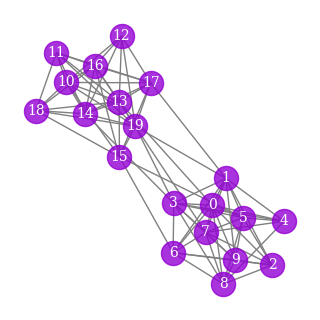

In [26]:
maxcut = gen_weightedMaxCut.WeightedMaxCut(q, seed, cut_loc, sizes, p_intra, p_inter, angles, save_plot, verbose)
weights = [random.uniform(0, 2 * np.pi) for _ in range(len(maxcut.G.edges))]
maxcut = gen_weightedMaxCut.WeightedMaxCut(q, seed, cut_loc, sizes, p_intra, p_inter, angles, save_plot, verbose, weights)
circ_objs = maxcut.run_all_cirq([1,2])

In [27]:
circuit_noblock, circuit_block = circ_objs

In [28]:
circuit_block

┌─────────────────┐   ┌─────────────────┐   ┌─────────────────────────────┐   ┌──────────────────────────┐   ┌──────────────────────────┐   ┌────────────────────────────────┐   ┌────────────────────────────────────┐   ┌────────────────────────────┐   ┌────────────────────────────────────┐   ┌───────────────────────────┐   ┌────────────────────────────┐   ┌──────────────────┐   ┌──────────────────┐   ┌─────────────────────────────────────────────────────────────────────────────────────────────┐                ┌──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐   ┌───────────────────────────────┐
0: ────H───ZZ──────────ZZ───────────ZZ────────────────────ZZ────────────────────ZZ────────────────────────────────ZZ─────────────────────────────ZZ─────────────────────────────ZZ───────────────────────────────────ZZ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────ZZ────────────Rx(0.741π)──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
           │           │            │                     │                     │                                 │                              │                              │                                    │                                                                                                                                                                     │
1: ────H───ZZ^(8/15)───┼────────────┼────────ZZ───────────┼───────ZZ────────────┼────────ZZ───────────────────────┼────────ZZ────────────────────┼───────ZZ─────────────────────┼───────ZZ───────────────────────────┼────────────────────────────────────────ZZ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┼──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────BlockGate(ZZ**2.9767946890421757(q(1), q(19)), ZZ**0.8120002566022317(q(3), q(19)), ZZ**2.5764862533101014(q(7), q(19)))───────────────ZZ─────────────────────────────────Rx(0.741π)───
                       │            │        │            │       │             │        │                        │        │                     │       │                      │       │                            │                                        │                                                                                                                            │                                                                                                                                                                          │                                                                                                                                      │
2: ────H───────────────ZZ^-0.581────┼────────ZZ^0.243─────┼───────┼─────────────┼────────┼────────────────────────┼────────┼─────────────────────┼───────┼─────────ZZ───────────┼───────┼───────ZZ───────────────────┼─────────ZZ─────────────────────────────┼─────────ZZ─────────────────────ZZ───────────────────────────────────────Rx(0.741π)─────────────────────────────────────────┼──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┼──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┼───────────────────────────────────────────────
                                    │          

In [30]:
start = time.time()
results_0 = run_qsimh(q, list(range(10)), 0, 1, 0, circuit_block)
end0 = time.time() - start
#print("qsimh result (block):")
#print(results_0)
print("qsimh (block) time: ", end0)

rmax: 2
smax: 16
Number of Feynman Paths: 32
qsimh (block) time:  0.6828362941741943


In [31]:
start = time.time()
results_1 = run_qsimh(q, list(range(10)), 0, 1, 0, circuit_noblock)
end1 = time.time() - start
#print("qsimh result (no block):")
#print(results_1)
print("qsimh (no block) time: ", end1)

rmax: 2
smax: 128
Number of Feynman Paths: 256
qsimh (no block) time:  2.8262529373168945


In [32]:
start = time.time()
results_2 = run_qsim(q, circuit_noblock)
end2 = time.time() - start
#print("qsim result (no cut):")
#print(results_2)
print("qsim (no cut) time: ", end2)

qsim (no cut) time:  0.34328389167785645


In [33]:
results_0 = np.array(results_0)
results_2 = np.array(results_2)
try:
    results_1 = np.array(results_1)
    print("Absolute difference between results (HSF joint v.s. separate): ", np.linalg.norm(results_0 - results_1))
except:
    print("Separate HSF was timed out.")
print("Absolute difference between results (HSF joint v.s. no cut): ", np.linalg.norm(results_0 - results_2))

Absolute difference between results (HSF joint v.s. separate):  5.063290509397306e-07
Absolute difference between results (HSF joint v.s. no cut):  5.347240948559612e-07


In [34]:
print("-----TIME RATIOS----")
print("separate/joint = ", end1/end0)
print("Schröd/joint = ", end2/end0)

-----TIME RATIOS----
separate/joint =  4.138990503917043
Schröd/joint =  0.502732345375718


Due to the small instance, the joint HSF is slower than Schrödinger here. But it is 4 times faster than the Standard HSF!

### $q=24$

In [20]:
q = 24
seed = 6
cut_loc = 12
sizes = [12,12]
p_intra = 0.8
p_inter = 0.05
angles = [1.55739, 2.32636]
save_plot = False
verbose = True
lim=int(1000000)

Cascades prior to limiting their size
('12', [(12, 13), (12, 14), (12, 15), (12, 17), (12, 20), (12, 22)])
('18', [(3, 18), (8, 18)])
('13', [(5, 13)])
('8', [(8, 19)])
('1', [(1, 23)])
('remainder', [(0, 1), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 10), (2, 3), (2, 5), (2, 6), (2, 9), (2, 10), (2, 11), (3, 4), (3, 5), (3, 7), (3, 8), (3, 9), (3, 10), (4, 6), (4, 7), (4, 8), (4, 11), (5, 6), (5, 7), (5, 8), (5, 9), (5, 10), (6, 7), (6, 8), (6, 9), (6, 10), (6, 11), (7, 8), (7, 9), (7, 10), (8, 9), (8, 10), (8, 11), (9, 10), (9, 11), (13, 14), (13, 15), (13, 16), (13, 17), (13, 18), (13, 19), (13, 20), (13, 21), (13, 22), (13, 23), (14, 15), (14, 16), (14, 17), (14, 18), (14, 19), (14, 20), (14, 21), (14, 23), (15, 16), (15, 18), (15, 19), (15, 20), (15, 21), (15, 22), (15, 23), (16, 17), (16, 19), (16, 20), (16, 23), (17, 18), (17, 19), (17, 20), (17, 21), (17, 22), (18, 19), (18, 20), (18, 21), (18, 2

/usr/local/lib/python3.10/dist-packages/networkx/drawing/nx_pylab.py:450: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


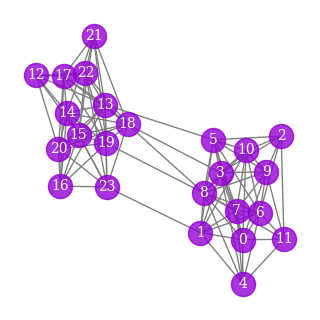

In [21]:
maxcut = gen_weightedMaxCut.WeightedMaxCut(q, seed, cut_loc, sizes, p_intra, p_inter, angles, save_plot, verbose)
weights = [random.uniform(0, 2 * np.pi) for _ in range(len(maxcut.G.edges))]
maxcut = gen_weightedMaxCut.WeightedMaxCut(q, seed, cut_loc, sizes, p_intra, p_inter, angles, save_plot, verbose, weights)
circ_objs = maxcut.run_all_cirq([1,2])

In [22]:
circuit_noblock, circuit_block = circ_objs

In [23]:
circuit_block

┌─────────────────┐   ┌───────────────────────────┐   ┌──────────────────────────┐   ┌───────────────────────────┐   ┌──────────────────────────────────┐   ┌─────────────────────────────────┐   ┌──────────────────────────────────────────┐   ┌──────────────────────────────────────────────┐   ┌────────────────────────────────────┐   ┌──────────────────────────────────┐   ┌────────────────────────────────────┐   ┌──────────────────────────┐   ┌─────────────────────────────┐   ┌───────────────────┐   ┌───────────────────┐   ┌──────────────────────────────────────────────────────────────────────────────────────────────────────┐   ┌────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
0: ────H───ZZ──────────ZZ──────────ZZ────────────────────ZZ──────────────────────────────ZZ─────────────────────────────ZZ──────────────────────────────ZZ─────────────────────────────────────ZZ────────────────────────────────────ZZ─────────────────────────────────────────────ZZ─────────────────────────────────────────────────Rx(0.741π)────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
           │           │           │                     │                               │                              │                               │                                      │                                     │                                              │
1: ────H───ZZ^-0.412───┼───────────┼────────ZZ───────────┼────────ZZ─────────────────────┼────────ZZ────────────────────┼────────ZZ─────────────────────┼───────ZZ─────────────────────────────┼────────ZZ───────────────────────────┼──────────────────────────────────────────────┼─────────ZZ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────ZZ────────────────────Rx(0.741π)───
                       │           │        │            │        │                      │        │                     │        │                      │       │                              │        │                            │                                              │         │                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           │
2: ────H───────────────┼───────────┼────────┼────────────┼────────┼─────────ZZ───────────┼────────┼─────────────────────┼────────┼────────ZZ────────────┼───────┼─────

In [24]:
start = time.time()
results_0 = run_qsimh(q, list(range(11)), 0, 1, 0, circuit_block, lim=lim)
end0 = time.time() - start
#print("qsimh result (block):")
#print(results_0)
print("qsimh (block) time: ", end0)

bitstrings generated
rmax: 2
smax: 32
Number of Feynman Paths: 64
qsimh (block) time:  2.231177568435669


In [25]:
start = time.time()
results_1 = run_qsimh(q, list(range(11)), 0, 1, 0, circuit_noblock, lim=lim)
end1 = time.time() - start
#print("qsimh result (no block):")
#print(results_1)
print("qsimh (no block) time: ", end1)

bitstrings generated
rmax: 2
smax: 1024
Number of Feynman Paths: 2048
qsimh (no block) time:  20.589306116104126


In [26]:
start = time.time()
results_2 = run_qsim(q, circuit_noblock, lim=lim)
end2 = time.time() - start
#print("qsim result (no cut):")
#print(results_2)
print("qsim (no cut) time: ", end2)

qsim (no cut) time:  2.699223756790161


In [29]:
results_0 = np.array(results_0)
results_2 = np.array(results_2)
try:
    results_1 = np.array(results_1)
    print("Absolute difference between results (HSF joint v.s. separate): ", np.linalg.norm(results_0 - results_1))
except:
    print("Separate HSF was timed out.")
print("Absolute difference between results (HSF joint v.s. no cut): ", np.linalg.norm(results_0 - results_2))

Absolute difference between results (HSF joint v.s. separate):  1.943121304032708e-07
Absolute difference between results (HSF joint v.s. no cut):  1.4193483187646007e-07


In [30]:
print("-----TIME RATIOS----")
print("separate/joint = ", end1/end0)
print("Schröd/joint = ", end2/end0)

-----TIME RATIOS----
separate/joint =  9.227999782437653
Schröd/joint =  1.2097754096204232


Here, not all amplitudes were computed but, instead, the number of amplitudes is limited by `lim`. The joint cutting is faster than the standard cutting and slightly faster than the Schrödinger simulation. To see more significant speedups, one has to work with larger systems (larger $q$). For those results, see the Benchmarks in `/weightedMaxCut`.